<font style="font-size: 3rem; color: darkviolet"> Convolutional Neural Networks in TensorFlow - *part 2* </font>

DEL - 2023/24 - TP3 (3h)

*This assignment is inspired by the Deep Learning course on Coursera by Andrew Ng, Stanford University, for which we are thankful.*

In this assignment, your task is to employ transfer learning on a pre-trained Convolutional Neural Network (CNN) to construct an Alpaca/Not Alpaca classifier. 

The pre-trained model, MobileNetV2, has already undergone training on the large ImageNet dataset, containing over 14 million images and 1000 classes. 

#### Main objectives:

- Augment data
- Adapt the pre-trained MobileNet model to the new data and task
- Fine-tune the final layers of the classifier to further improve the accuracy of the model


### Table of Contents
- [1 - Dataset Preparation and Data Augmentation](#1)
- [2 - Using MobileNetV2 for Transfer Learning](#2)
    - [2.1 - Fine-tuning the top layers](#3)
    - [2.2 - Fine-tuning the model](#4)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers

from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
np.random.seed(1)

<a name='1'></a>
## <font color='darkviolet'> 1 - Dataset Preparation and Data Augmentation

<a name='ex-1.1'></a>
### <font color='blue'> Exercise 1 - Dataset preparation
    
<font color='blue'> **1.1** <font color='black'> This exercise focuses on using the `ImageDataGenerator` module in TensorFlow to dynamically generate batches of tensor image data, incorporating real-time data augmentation directly from a specified directory. The `flow_from_directory()` method simplifies the creation of training and validation datasets. During this step, the images will be preprocessed, including resizing to a specified dimension.
    
For a comprehensive understanding of the implementation process, refer to the documentation available at:
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator    
    
Note: Ensuring the use of the same `seed` guarantees consistency in the split between training and validation datasets.

To enhance diversity in the training set and facilitate improved learning by the model, image augmentation involves random transformations such as flipping and rotating. Implement the following augmentations for the training set :
* Rescaling: `rescale=1./255` normalizes pixel values to the range [0, 1].

* Zooming: `rotation_range=0.2` randomly rotate images by a degree range.

* Horizontal Flipping: `horizontal_flip=True` randomly flips images horizontally.

In [2]:
data_dir = "dataset/"
batch_size = 32
img_size = (128,128)
validation_split = 0.2

'''augmented_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    preprocessing_function=None,
    data_format=None,
    validation_split=validation_split,
)'''

augmented_generator = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=0.2,
    rescale=1./255,
    validation_split=validation_split,
)

# Create data generator with data augmentation for training set
train_generator = augmented_generator.flow_from_directory(
    data_dir,  # This is the target directory
    target_size=img_size,  # All images will be resized to 128x128
    batch_size=batch_size,
    class_mode='categorical',  # Since we use binary_crossentropy loss, we need binary labels
    shuffle=True,
    seed=1200,
    subset='training'
)

# Create data generator with or without data augmentation for validation set
validation_generator = augmented_generator.flow_from_directory(
    data_dir,  # This is the target directory
    target_size=img_size,  # All images will be resized to 128x128
    batch_size=batch_size,
    class_mode='categorical',  # Since we use binary_crossentropy loss, we need binary labels
    shuffle=True,
    seed=1200,
    subset='validation'
)

class_indices = list(train_generator.class_indices.keys())


Found 262 images belonging to 2 classes.
Found 65 images belonging to 2 classes.


<font color='blue'> **1.2** <font color='black'> Explore your dataset: dimensions, size, labels, and plot a few images. 

In [3]:
print("Labels:", class_indices)

Labels: ['alpaca', 'not alpaca']


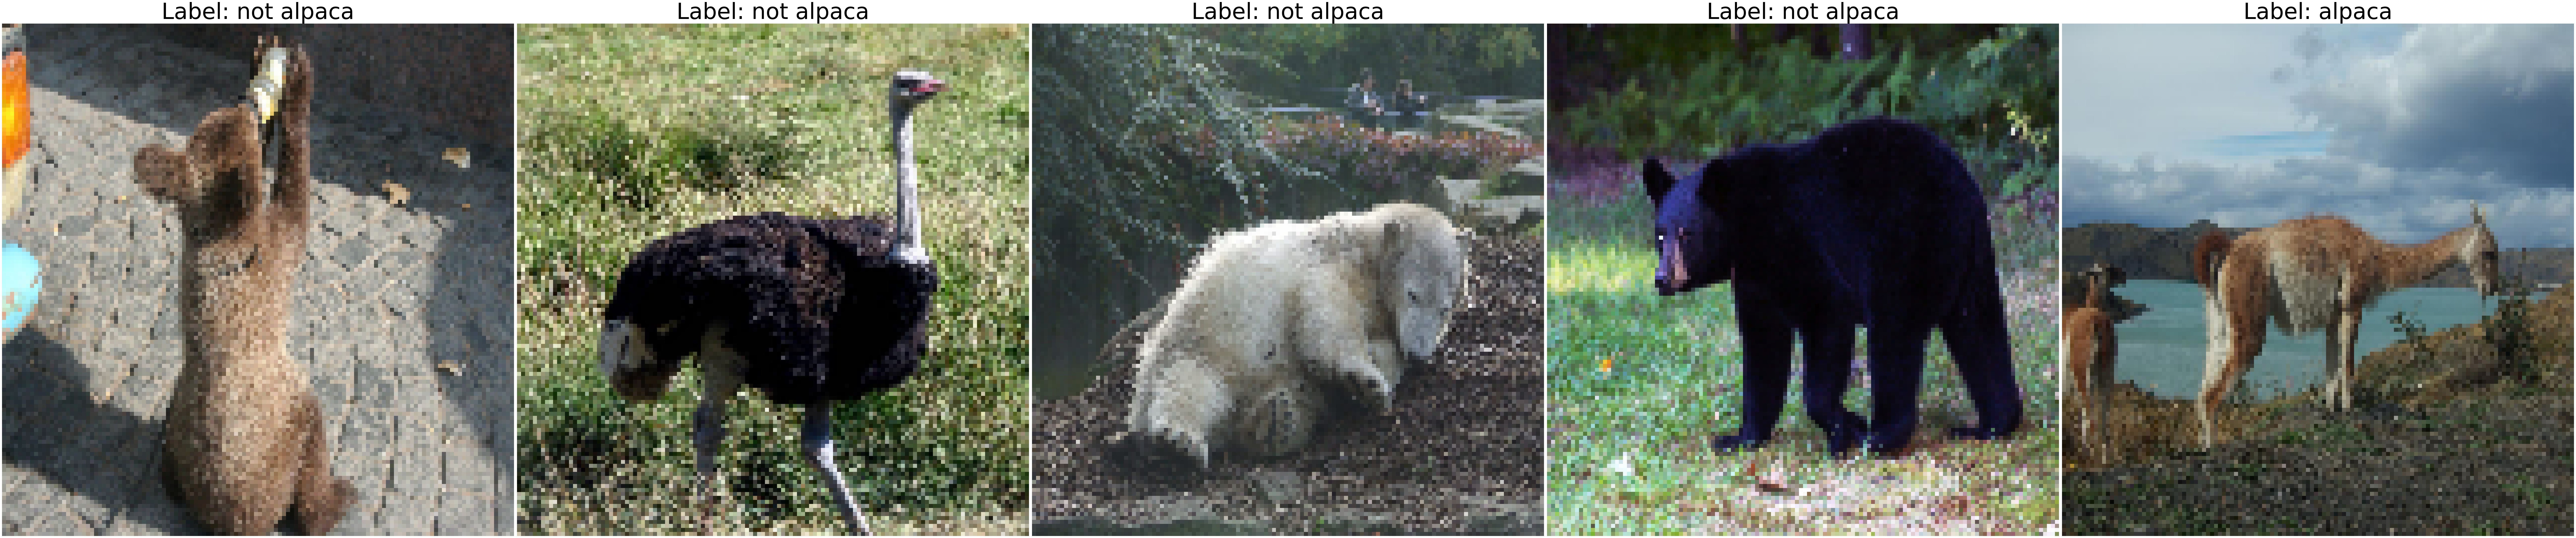

Train shape: (32, 128, 128, 3)


In [4]:
# Function to plot images
def plot_images(images_arr, labels_arr):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(128, 128))
    axes = axes.flatten()
    for img, label, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        label = class_indices[np.argmax(label)]
        ax.set_title(f'Label: {label}', fontsize=80)
    plt.tight_layout()
    plt.show()

# Get a batch of images and labels from the training set
train_images, train_labels = next(train_generator)

# Plot a few images from the training set
plot_images(train_images[:5], train_labels[:5])  # Adjust the number of images you want to display

print(f'Train shape: {train_images.shape}')

In [5]:
train_labels = next(train_generator)[1]
train_labels.shape

(32, 2)

<a name='2'></a>
## <font color='darkviolet'> 2 - Using MobileNetV2 for Transfer Learning

MobileNetV2 was trained on the ImageNet dataset for the task of image classification. The pretrained MobileNetV2 model serves as a starting point for transfer learning on the similar task of binary image classification.
    
Note: Since the pre-trained MobileNetV2 model was originally trained using normalization values in the range of [-1, 1], it's considered best practice to use the same normalization standard for your input data. You can achieve this by using the `tf.keras.applications.mobilenet_v2.preprocess_input` function.
    
Obtain the pre-trained MobileNetV2 model with weights learned from the ImageNet dataset:

In [6]:
# Load MobileNetV2 with the top layer
base_model = tf.keras.applications.MobileNetV2(input_shape=(128,128, 3), include_top=True, weights='imagenet')

# Get a summary of the architecture and parameters
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

<a name='3'></a>
### <font color='blue'> Exercise 2 - Fine-tuning on the top layers
    
<font color='blue'> **2.1** <font color='black'>  Adapting the pre-trained model for the targeted task of recognizing alpacas involves the following steps:

1. Remove the top layer (classification layer) used for the original classification task;
2. Add a new classification layer specifically designed for the task of recognizing alpacas;
3. Freeze the base model ensuring the existing weights remain unchanged, allowing only training on the newly introduced layer(s); the frozen layers act as a feature extractor, and the training process focuses on fine-tuning the top layers for the specific task.
    
Consult the documentation as needed: https://keras.io/guides/transfer_learning/#introduction

In [7]:
from keras import Model
from keras.layers import Dense, GlobalAveragePooling2D

# Load MobileNetV2 without the top layer
base_model = tf.keras.applications.MobileNetV2(input_shape=(128,128, 3), include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
top_layer = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=top_layer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

<font color='blue'> **2.2** <font color='black'> Train only the new classificayion layer. Plot and observe the training and validation accuracy.

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'best_model.h5',            # The filepath where the model will be saved
    monitor='val_accuracy',     # The performance metric to monitor
    save_best_only=True         # Only save a model if `val_accuracy` has improved
)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',     # The performance metric to monitor
    patience=10                  # Number of epochs with no improvement after which training will be stopped
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=40,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/40
9/9 [==============================] - 20s 748ms/step - loss: 0.8245 - accuracy: 0.5000 - val_loss: 0.9091 - val_accuracy: 0.4462
Epoch 2/40
9/9 [==============================] - 4s 493ms/step - loss: 0.7497 - accuracy: 0.5458 - val_loss: 0.8309 - val_accuracy: 0.5077
Epoch 3/40
9/9 [==============================] - 4s 497ms/step - loss: 0.7128 - accuracy: 0.5954 - val_loss: 0.7668 - val_accuracy: 0.5231
Epoch 4/40
9/9 [==============================] - 4s 539ms/step - loss: 0.6663 - accuracy: 0.6679 - val_loss: 0.7662 - val_accuracy: 0.6154
Epoch 5/40
9/9 [==============================] - 4s 453ms/step - loss: 0.6331 - accuracy: 0.7214 - val_loss: 0.7519 - val_accuracy: 0.5846
Epoch 6/40
9/9 [==============================] - 4s 502ms/step - loss: 0.6173 - accuracy: 0.7557 - val_loss: 0.7131 - val_accuracy: 0.6308
Epoch 7/40
9/9 [==============================] - 4s 479ms/step - loss: 0.5957 - accuracy: 0.7672 - val_loss: 0.6879 - val_accuracy: 0.7385
Epoch 8/40
9/9 [===

In [9]:
def plot_things(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    plt.show()

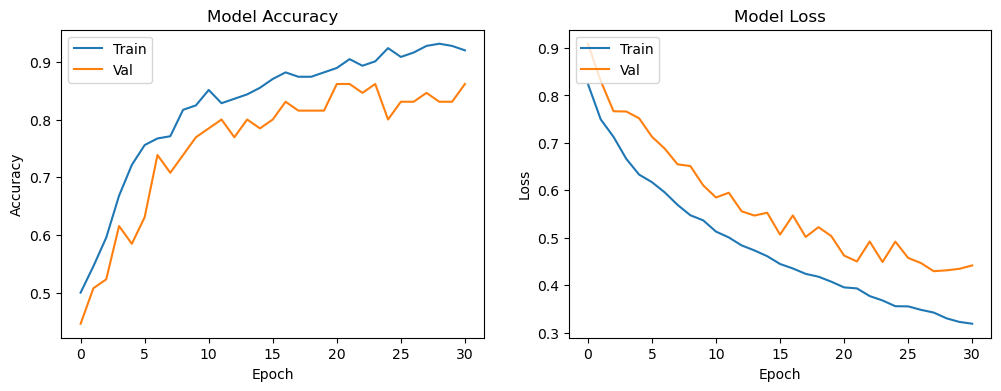

In [10]:
plot_things(history)

<a name='3'></a>
### <font color='blue'> Exercise 3 - Fine-tuning the model

<font color='blue'> **3.1** <font color='black'> To initiate this fine-tuning process, unfreeze the layers at the end of the network. Specify the layer from which fine-tuning begins and re-freeze all preceding layers. 
    
Re-run the training for additional epochs and assess whether this fine-tuning improves the model's accuracy.    
Feel free to experiment with the starting layer for fine-tuning, as the specific choice is somewhat arbitrary. 
    
The crucial aspect is that the later layers capture finer details relevant to the specific task at hand, such as distinguishing alpacas based on distinctive features like pointy ears and hairy tails.
    
Employing a smaller learning rate ensures smaller adjustments to better accommodate the specifics of the new dataset.

In [11]:
base_model.trainable = False

# Unfreeze the last N layers
N = 5  #Unfreeze the last 5 layers
for layer in base_model.layers[-N:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
top_layer = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=top_layer)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']         

<font color='blue'> **3.1** <font color='black'> Train the model. Plot and observe the training and validation accuracy.

In [12]:
model.compile(optimizer=Adam(learning_rate=0.00001), loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=40,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/40
9/9 [==============================] - 8s 553ms/step - loss: 0.8530 - accuracy: 0.4695 - val_loss: 0.8570 - val_accuracy: 0.5385
Epoch 2/40
9/9 [==============================] - 4s 472ms/step - loss: 0.7576 - accuracy: 0.5992 - val_loss: 0.7814 - val_accuracy: 0.6154
Epoch 3/40
9/9 [==============================] - 5s 516ms/step - loss: 0.6947 - accuracy: 0.6489 - val_loss: 0.7284 - val_accuracy: 0.6923
Epoch 4/40
9/9 [==============================] - 5s 507ms/step - loss: 0.6568 - accuracy: 0.6908 - val_loss: 0.7066 - val_accuracy: 0.6615
Epoch 5/40
9/9 [==============================] - 5s 554ms/step - loss: 0.6163 - accuracy: 0.7519 - val_loss: 0.6996 - val_accuracy: 0.6615
Epoch 6/40
9/9 [==============================] - 5s 511ms/step - loss: 0.5659 - accuracy: 0.7748 - val_loss: 0.6522 - val_accuracy: 0.7385
Epoch 7/40
9/9 [==============================] - 5s 553ms/step - loss: 0.5283 - accuracy: 0.7939 - val_loss: 0.6363 - val_accuracy: 0.7077
Epoch 8/40
9/9 [====

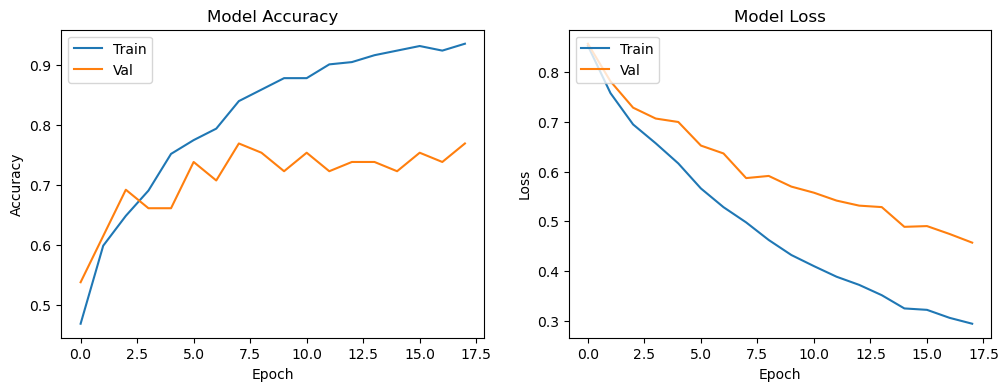

In [13]:
plot_things(history)

**Feel free to experiment with different strategies for data augmentation, fine-tuning, and custom layers.**

Now a new model unfreezing only certain layers

In [14]:
base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
top_layer = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=top_layer)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']         

In [15]:
model.compile(optimizer=Adam(learning_rate=0.00001), loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=40,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/40
9/9 [==============================] - 13s 790ms/step - loss: 0.8132 - accuracy: 0.5153 - val_loss: 0.7921 - val_accuracy: 0.5385
Epoch 2/40
9/9 [==============================] - 6s 740ms/step - loss: 0.7341 - accuracy: 0.5534 - val_loss: 0.7713 - val_accuracy: 0.5692
Epoch 3/40
9/9 [==============================] - 7s 711ms/step - loss: 0.6690 - accuracy: 0.6183 - val_loss: 0.7574 - val_accuracy: 0.5692
Epoch 4/40
9/9 [==============================] - 6s 766ms/step - loss: 0.6197 - accuracy: 0.6641 - val_loss: 0.7147 - val_accuracy: 0.5846
Epoch 5/40
9/9 [==============================] - 6s 675ms/step - loss: 0.5583 - accuracy: 0.7099 - val_loss: 0.6828 - val_accuracy: 0.6000
Epoch 6/40
9/9 [==============================] - 6s 637ms/step - loss: 0.5043 - accuracy: 0.8092 - val_loss: 0.6460 - val_accuracy: 0.5846
Epoch 7/40
9/9 [==============================] - 6s 638ms/step - loss: 0.4831 - accuracy: 0.7863 - val_loss: 0.6134 - val_accuracy: 0.6462
Epoch 8/40
9/9 [===

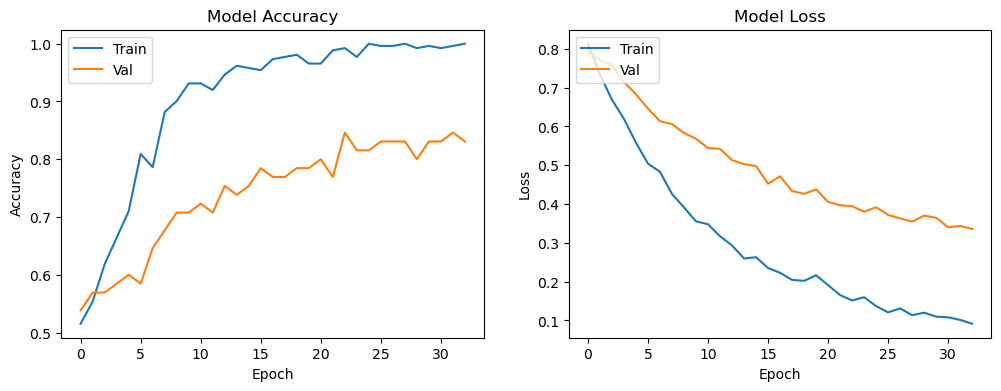

In [16]:
plot_things(history)